#### Package Imports:

In [1]:
#Numpy
import numpy as np

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
%matplotlib inline
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm

#For file reading
import glob as glob
import re
import os

#Scipy packages
import scipy.optimize

#For image plotting
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.transform

#For identifying aster center
from skimage.filters import threshold_otsu
from skimage.measure import regionprops
import cv2

#for image registration
# import skimage.registration
from skimage.registration import phase_cross_correlation
# from skimage.registration._phase_cross_correlation import _upsampled_dft


#For interactive features
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets

import pandas as pd

from tqdm.notebook import tqdm as tqdm

import panel as pn
pn.extension()

### A conglomeration of functions

In [2]:
def file_to_image(files):
    """
    Takes in a file list and converts to images.
    
    Parameters:
    files: list of file names that you want to read into images
    
    Returns:
    An array of np.int16 images
    """
    im_list=list()
    for file in files:
        im = skimage.io.imread(file)
        im_list.append(im.astype(np.int16))
    
    return np.array(im_list)

<font color = 'purple'>
interp_fn takes an image and places a mask over the center aster region. from the the outside values the function interpolates what the interior of the image should look like. This corrects for an image where the first frame is photobleached - Neutral to channels   
</font>

In [3]:
def interp_fn(im, mask, max_power):
    """
    Perform a 2D polynomial interpolation of the image.
    
    Parameters
    ----------
    im : numpy array
        Image to be interpolated
        
    mask : numpy array
        A matrix with binary values of the same size as im.
        The value at a location is 1 if that pixel is considered
        as an input in the interpolation procedure.
        
    max_power : integer
        Highest power for any of the coordinates in the 
        interpolation function f(x,y) = \sum_{ij} a_{ij} x^i y^j
        
    Returns
    -------
    im_interp : numpy array
        Interpolated image
    """
    
    H, W = im.shape
    X, Y = np.meshgrid(np.arange(W)-0.5*W, np.arange(H)-0.5*H)
    i_set = []
    j_set = []
    
    n_ind = max_power + 1
    
    for i in range(n_ind):
        for j in range(n_ind):
            i_set.append(i)
            j_set.append(j)
            
    b_vec = np.zeros(n_ind**2)
    for n in range(n_ind**2):
        i = i_set[n]
        j = j_set[n]
        b_vec[n] = np.sum(X**i * Y**j * im * mask)
        
    A_mat = np.zeros([n_ind**2,n_ind**2])
    for n in range(n_ind**2):
        for m in range(n_ind**2):
            i = i_set[n]
            j = j_set[n]
            
            i_tilde = i_set[m]
            j_tilde = j_set[m]
            
            A_mat[n,m] = np.sum(X**(i+i_tilde) * Y**(j+j_tilde) * mask)
    
    a_vec = np.linalg.solve(A_mat, b_vec)
    
    im_interp = np.zeros([H, W])
    for n in range(n_ind**2):
        i = i_set[n]
        j = j_set[n]
        im_interp += a_vec[n] * X**i * Y**j
    
    # Subtract the camera offset (NEW)
    im_interp -= offset_camera
        
    return im_interp

In [4]:
#Original vahe ftn which i use for the motors
def norm_mat_fn_mot(im_ref, offset_camera, r_blur=20):
    """
    Generate a normalization matrix from a reference image.
    
    It is assumed that the reference image is taken for a sample
    with a spatially uniform protein concentration. The normalization
    value is everywhere greater than 1, except at the position of 
    the highest illumination.
    
    Parameters
    ----------
    im_ref : numpy array
        Reference image (e.g., the first frame in the MT channel).
    
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    r_blur : float
        Radius of blurring to be performed on the reference image 
        in order to remove noise and short length scale nonuniformities [px].
        
    Returns
    -------
    norm_mat : numpy array
        Normalization matrix
    """
    
    # Convert image into a float type
    im_ref = im_ref.astype(float)
    
#     # Subtract the camera offset (REMOVED FROM HERE AND INPUTTED INTO THE INTERPOLATED FTN BECAUSE I DO THAT FIRST)
#     im = im_ref - offset_camera
    
    # Rescale the image down for faster denoising
    rescale = 4.0
    im_resized = skimage.transform.rescale(im_ref, 1/rescale)
    
    # Median filter to remove hot pixels
    im_median = skimage.filters.median(im_resized, skimage.morphology.selem.disk(3.0))
    
    # Gaussian blur the image
    im_blur = skimage.filters.gaussian(im_median, r_blur)
    
    # Find the location of the peak
    ind_max = np.where(im_blur == im_blur.max())
    i_center, j_center = ind_max[0][0], ind_max[1][0]
    print("The vertical coordinate for the fluor peak is at " +str(i_center*rescale))
    print("The horizontal coordinate for the fluor peak is at " +str(j_center*rescale))
    
    # Peak fluorescence in the normalization image
    fluo_peak = im_blur[i_center, j_center]
    print("The fluo peak intensity value is " + str(fluo_peak))
    
    # Normalization matrix
    norm_mat = fluo_peak/im_blur 
    
    # Scale up the normalization matrix to the original size
    norm_mat = skimage.transform.rescale(norm_mat, rescale)
    
    return norm_mat

In [5]:

#Vahe uses r_blur = 20 and skimage.morphology.selem.disk(3.0). I pick r_blur=3 and disk 
#size 10 by trial and error it looks like this leaves the least ring from blurring in iATP
#and the median filter of 10 does the best smooth

def norm_mat_fn_iATP(im_ref, offset_camera, r_blur=3):
    """
    Generate a normalization matrix from a reference image.
    
    It is assumed that the reference image is taken for a sample
    with a spatially uniform protein concentration. The normalization
    value is everywhere greater than 1, except at the position of 
    the highest illumination.
    
    Parameters
    ----------
    im_ref : numpy array
        Reference image (e.g., the first frame in the MT channel).
    
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    r_blur : float
        Radius of blurring to be performed on the reference image 
        in order to remove noise and short length scale nonuniformities [px].
        
    Returns
    -------
    norm_mat : numpy array
        Normalization matrix
    """
    
    # Convert image into a float type
    im_ref = im_ref.astype(float)
    
#     # Subtract the camera offset
#     im = im_ref - offset_camera
    
    # Rescale the image down for faster denoising
    rescale = 4.0
    im_resized = skimage.transform.rescale(im_ref, 1/rescale)
    
    # Median filter to remove hot pixels
    im_median = skimage.filters.median(im_resized, skimage.morphology.selem.disk(10.0))
    
    # Gaussian blur the image
    im_blur = skimage.filters.gaussian(im_median, r_blur)
    
    # Find the location of the peak
    ind_max = np.where(im_blur == im_blur.max())
    i_center, j_center = ind_max[0][0], ind_max[1][0]
    
    # Peak fluorescence in the normalization image
    fluo_peak = im_blur[i_center, j_center]
    
    # Normalization matrix
    norm_mat = fluo_peak/im_blur 
    
    # Scale up the normalization matrix to the original size
    norm_mat = skimage.transform.rescale(norm_mat, rescale)
    
    return norm_mat

In [6]:
def calibrate_motor(im, norm_mat, offset_camera, auto_fluo, protein_per_fluo):
    """
    Calibrate a fluorescence image using the normalization matrix and
    the intensity calibration factor.
    
    Parameters
    ----------
    im : numpy array
        Image to be calibrated.
    
    norm_mat : numpy array
        Normalization matrix.
        
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    auto_fluo : float
        Autofluorescence (coming from the energy mix).
        
    protein_per_fluo : float
        Calibration factor for converting fluorescence units
        into protein concentration units.
        
    Returns
    -------
    im : numpy array
        Calibrated image.
    """
    
    im = im.astype(float)
    im = skimage.filters.median(im)
    im = im - offset_camera
    im = im * norm_mat
    im = im - auto_fluo
    im = im * protein_per_fluo
    return im

In [7]:
#Intensity to µM iATP calibration function

def calibrate_iATP(im, norm_mat, offset_camera, auto_fluo, C_half, I_range, I_0):
    """
    Calibrate a fluorescence image using the normalization matrix and
    the intensity calibration factor.
    
    Parameters
    ----------
    im : numpy array
        Image to be calibrated.
    
    norm_mat : numpy array
        Normalization matrix.
        
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    auto_fluo : float
        Autofluorescence (coming from the energy mix).
        
    I_range : float
        Coefficient in Languimuir Binding
        
    I_0 : float
        Additive "b-intercept" in Languimuir binding.
        
    C_half : float
        Concentration at half max intensity.
        
    Returns
    -------
    im : numpy array
        Calibrated image.
    """
    
    im = im.astype(float)
    im = skimage.filters.median(im)
    im = im - offset_camera 
    im = im * norm_mat
    im = im - auto_fluo
    im = (C_half*(im - I_0)) / (I_range - im + I_0)
    
    neg_vals = np.where(im < 0)
    
    return im

In [8]:
def profile_fn_nowedge(im, r_min=2.5, dr=1.5, r_max=None, avg_method='median', n_positions=100):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    im : numpy array
        The cropped image of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """
    
    # Ensure that the image is a numpy array
    if not isinstance(im, np.ndarray):
        im = np.array(im)
    
    # Dimensions of the image
    H,W = im.shape
    
    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5*W-0.5
    y_center = 0.5*H-0.5
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)    
    
    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    im_ls = im.flatten()
    
    avg_ls = np.zeros(n_positions)
    std_ls = np.zeros(n_positions)
    
    # Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
    if r_max == None:
        r_max = 0.5*np.min([H,W])-0.5
    r_unif_ls = np.linspace(r_min, r_max, n_positions)
    
    for i, r in enumerate(r_unif_ls):
        dat = im_ls[(r_ls > r-0.5*dr) & (r_ls < r+0.5*dr)]

        if avg_method == 'median':
            avg_ls[i] = np.median(dat)
        elif avg_method == 'mean':
            avg_ls[i] = np.mean(dat)
        else:
            raise ValueError('Incorrect averaging method specified.')

        std_ls[i] = np.std(dat)
    
    # Keep only the points inside the disk
    im_ls = im_ls[r_ls <= r_max]
    r_ls = r_ls[r_ls <= r_max]
    
    profile_output = {"r_unif_ls" : r_unif_ls,
                      "avg_ls"    : avg_ls,
                      "std_ls"    : std_ls,
                      "r_ls"      : r_ls,
                      "im_ls"     : im_ls}
    
    return profile_output

In [9]:
def profile_fn(im, r_min=2.5, dr=1.5, r_max=None, avg_method='median', n_positions=100, n_wedge=16):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    im : numpy array
        The cropped image of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
    n_wedge : integer
        Number of angular bins
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """
    
    # Ensure that the image is a numpy array
    if not isinstance(im, np.ndarray):
        im = np.array(im)
    
    # Dimensions of the image
    H,W = im.shape
    
    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5*W-0.5
    y_center = 0.5*H-0.5
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)    
    angle_mat = np.mod(np.arctan2(y_mat-y_center, x_mat-x_center), 2*np.pi)

    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    im_ls = im.flatten()
    angle_ls = angle_mat.flatten()

    
    # Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
    if r_max == None:
        r_max = 0.5*np.min([H,W])-0.5
    r_unif_ls = np.linspace(r_min, r_max, n_positions)
    
    # List of bin angles 
    angle_bins = np.radians(np.linspace(0,360,n_wedge+1)) 
    angles = 0.5*(angle_bins[1:] + angle_bins[0:-1])

    # Matrix to store average profiles in each radial bin 
    avg_bin_mat = [[] for _ in range(n_wedge)]

    for i, r in enumerate(r_unif_ls):
        dat = im_ls[(r_ls > r-0.5*dr) & (r_ls < r+0.5*dr)]
        angle_disk = angle_ls[(r_ls > r-0.5*dr) & (r_ls < r+0.5*dr)]

        for k in range(n_wedge):
            dat_bin = dat[(angle_disk>angle_bins[k]) & (angle_disk<=angle_bins[k+1])]
            if avg_method == 'median':
                avg_dat_bin = np.median(dat_bin)
            elif avg_method == 'mean':
                avg_dat_bin = np.mean(dat_bin)
            avg_bin_mat[k].append(avg_dat_bin)
            
          
    avg_bin_mat = np.array(avg_bin_mat)
    if avg_method == 'median':
        avg_ls = np.median(avg_bin_mat, axis=0)
    elif avg_method == 'mean':
        avg_ls = np.mean(avg_bin_mat, axis=0)
    else:
        raise ValueError('Incorrect averaging method specified.')
   
    std_ls = np.std(avg_bin_mat, axis=0)

    # Keep only the points inside the disk 
    im_ls = im_ls[r_ls <= r_max] 
    r_ls = r_ls[r_ls <= r_max]
    
    profile_output = {"r_unif_ls" : r_unif_ls, 
                      "avg_ls" : avg_ls, 
                      "std_ls" : std_ls, 
                      "avg_bin_mat" : avg_bin_mat, 
                      "angles" : angles, 
                      "r_ls" : r_ls, 
                      "im_ls": im_ls}

    return profile_output

In [10]:
def binary_im_generator(im_for_binary, percentile = 80):
    """
    Creates an image of ones for values above a threshold and zeros for all others. 
    This is essentially a mask. The image is the same size as the inputted image.
    
    Parameters:
    im_for_binary: image you wish to create a mask from
    percentile: uses the np.percentile function which thresholds above 
                the given percentile. Automatically set to 80
                
    Returns:
    A binary image to be used as a mask
    """
    
    im_binary = im_for_binary > np.percentile(im_for_binary, percentile)
    
    #plot the figures
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16,8))

    loc0 = ax0.imshow(im_for_binary)
    fig.colorbar(loc0, ax=ax0, shrink = 0.5)
    ax0.set_title("inputted image")

    loc1 = ax1.imshow(im_binary, cmap = plt.cm.Greys_r)
    fig.colorbar(loc1, ax=ax1, shrink = 0.5)
    ax1.set_title("binary image")
    
    return im_binary

In [11]:
def find_center(im, w_half, r_thresh, r_blur, motor, \
                least_squares = True, n_search_half = 5, n_positions = 40):
    """
    Identify the center coordinates of the aster.
    
    Parameters
    ----------
    im : numpy array
        Cropped fluorescence image of motors or microtubules where the aster center is
        close to the image center.
        
    w_half : float
        Half the size of the window of points that are considered for 
        center identification.
        
    r_thresh : float
        Radius of the small circle of points that are excluded from the center
        identification procedure. This is used to prevent biasing the center
        due to high-intensity spots in the core.
        
    r_blur : float
        Size of Gaussian blurring for initial guessing of the center.
    
    least_squares : Boolean
        Indicator variables that is true is the least squares optimization is
        used (faster), and is false if a window search is used (slower).
        
    n_search_half : int
        Half the size of the window around the initial guess where the center
        is looked for.
        
    n_positions : int
        Number of positions considered when extracting radial profiles.
        
        
    Returns
    -------
    i_center : int
        i-coordinate of identified center
    
    j_center : int
        j-coordinate of identified center
    """
    length = im.shape[0]
    
    # Initial guess of the aster center
    i_max, j_max = int(0.5*length), int(0.5*length)

    def find_sd(location):
        """
        Calculate the array of standard deviations for a profile
        centered at 'location'.
        """
        # Current coordinates of the aster center
        i_curr, j_curr = location
        
        # Nearest integer coordinates
        ii = [int(i_curr), int(i_curr)+1]
        jj = [int(j_curr), int(j_curr)+1]
        
        # Array to store the average cropped images,
        # obtained by areal weighting of 4 contributions
        im_crop = np.zeros([2*w_half+1,2*w_half+1])
        w_tot = 0
        for i in ii:
            for j in jj:
                weight = (1-np.abs(i_curr-i))*(1-np.abs(j_curr-j))
                w_tot += weight
                im_crop += weight*im[i-w_half:i+w_half+1, j-w_half:j+w_half+1]
        
        profile_output = profile_fn(im_crop, r_thresh, n_positions = n_positions)
        std_ls = profile_output["std_ls"]
        return std_ls
    
    if least_squares:
        cost = np.inf
        param_init = [i_max, j_max]

        output = scipy.optimize.least_squares(find_sd, param_init, method="lm")
        i_center, j_center = output.x

        i_center = int(round(i_center))
        j_center = int(round(j_center))
    else:
        search_range = np.arange(-n_search_half, n_search_half)
        di_m, dj_m = np.meshgrid(search_range, search_range)
        std_sq_min = np.inf
        di_opt = 0
        dj_opt = 0

        for i in range(len(search_range)):
            for j in range(len(search_range)):
                i_curr = i_max + di_m[i,j]
                j_curr = j_max + dj_m[i,j]

                im_crop = im[i_curr-w_half:i_curr+w_half+1, j_curr-w_half:j_curr+w_half+1]
                profile_output = profile_fn(im_crop, r_thresh)
                std_ls = profile_output["std_ls"]
                
                if np.mean(std_ls**2) < std_sq_min:
                    di_opt = di_m[i,j]
                    dj_opt = dj_m[i,j]
                    std_sq_min = np.mean(std_ls**2)
        
        i_center = i_max + di_opt
        j_center = j_max + dj_opt

    return i_center, j_center

In [12]:
def remove_spots(im_motor, motor_bg, size=9, multi=2.0):
    """
    An auxiliary function that removes bright spots in motor images,
    which primarily occur in the core region.
    
    Parameters
    ----------
    im_motor : numpy array
        Cropped image in the motor (YFP) channel.
        
    motor_bg : float
        Background motor fluorescence.
        
    size : int
        Side length of small square regions considered in the
        spot removal procedure.
        
    multi : float
        Multiplicative factor that sets the threshold of identifying
        a pixel as a 'bright spot.' Specifically, if the difference
        between the pixel intensity and the median intensity of the local
        region exceeds the background motor fluorescence by at least this
        multiplicative factor, then the pixel is identified as a 'bright
        spot.'
        
    
    Returns
    -------
    im_motor : numpy array
        Cropped image with the bright spots removed.
    """
    H, W = im_motor.shape
    for i in range(0,H,size):
        for j in range(0,W,size):
            # Local window
            im = im_motor[i:i+size,j:j+size]
            
            # Spot identification
            im[im > multi*motor_bg + np.median(im)] = np.median(im)
            
            # Update the window in the image
            im_motor[i:i+size,j:j+size] = im
    
    return im_motor

### Import Images

#### Analysis parameters:

In [13]:
# Length calibration [microns per pixel]
um_per_pixel = 0.59

# Image dimensions
w_px, h_px = 1920, 1200
w_um, h_um = w_px*um_per_pixel, h_px*um_per_pixel

# Method for doing intensity averaging in a radial bin; choose from {'mean', 'median'}
avg_method = 'median'

# Colors used for plotting
color_motor = np.array([122.0, 169.0, 116.0])/255
color_iATP = np.array([115.0, 143.0, 193.0])/255
color_background = '#E5E0D5'

Fill out all the relevant path information for importing the dataset:

In [14]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../../../Aster_Energy_Data/Aster/2022-05-02_BL21K401_ATEAM_R4/images/'

#Choose the position(s)/aster(s) of interest:
pos_list = ['pos0']

#Choose the channels of interest (this is almost always going to be Cherry and iATP)
channel_list = ['Bright', 'CFP', 'YFP']

#included frames
included_frames = '*2022*.tif'

Automated cell to import the images

In [15]:
for pos in pos_list:
        for channel in channel_list:
            
            #creates an empty list with the naming convention
            exec('im_files'+channel+pos + '= []')
            im_files = eval('im_files'+channel+pos)
            #appends all the file names
            im_files.append(np.sort(glob.glob(file_path + '/' + pos + '/' + channel + '/' + included_frames)))

            #Reads the files as images
            exec('im_array'+channel+pos + ' = file_to_image(im_files[0])')
            print('im_array'+channel+pos)
            
file_path = '../../../../Aster_Energy_Data/Aster/2022-03-25/2022-03-25_ATEAM_BL21-K401_Dark_1/images/'
file_name = '-2022-03-25_ATEAM_BL21-K401_Dark_1_MMStack_Pos0.ome.tif'

im_MT_dark = skimage.io.imread(file_path + 'C1' + file_name).astype(np.int16)
im_YFP_dark = skimage.io.imread(file_path + 'C2' + file_name).astype(np.int16)
im_CFP_dark = skimage.io.imread(file_path + 'C3' + file_name).astype(np.int16)

im_arrayBrightpos0
im_arrayCFPpos0
im_arrayYFPpos0


In [45]:
print(np.max(im_arrayYFPpos0[0]))
print(np.percentile(im_arrayYFPpos0[0], 0))
print(np.max(im_YFP_dark))
print(np.percentile(im_YFP_dark, 0))

2432
1872.0
2144
1872.0


In [26]:
test = []
for i, im in enumerate(im_arrayCFPpos0):
    testim = im - im_CFP_dark
    test.append(testim)

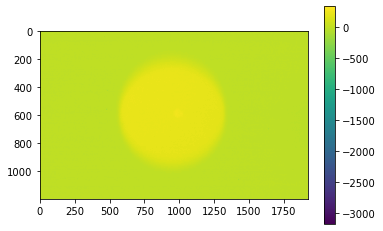

In [31]:
plt.imshow(im_arrayCFPpos0[30] - im_CFP_dark)
plt.colorbar()

In [16]:
im_arrayBrightpos0_bs = im_arrayBrightpos0 - im_MT_dark
im_arrayCFPpos0_bs = im_arrayCFPpos0 - im_CFP_dark
im_arrayYFPpos0_bs = im_arrayYFPpos0 - im_YFP_dark

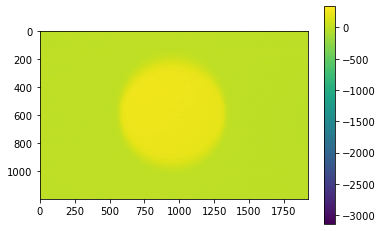

In [21]:
frame = 0
plt.imshow(im_arrayCFPpos0_bs[frame])
plt.colorbar()

Import dark images - the dark images were taken at 1000mA light, while the dataset was taken at 100mA light. This corresponds to 24% of the light.

In [16]:
file_path = '../../../../Aster_Energy_Data/Aster/2022-03-25/2022-03-25_ATEAM_BL21-K401_Dark_1/images/'
file_name = '-2022-03-25_ATEAM_BL21-K401_Dark_1_MMStack_Pos0.ome.tif'
 
im_MT_dark = skimage.io.imread(file_path + 'C1' + file_name).astype(np.int16)
im_YFP_dark = skimage.io.imread(file_path + 'C2' + file_name).astype(np.int16)
im_CFP_dark = skimage.io.imread(file_path + 'C3' + file_name).astype(np.int16)

# Reduce the light:
percent_light = 1
im_MT_dark_rd = im_MT_dark * percent_light
im_YFP_dark_rd = im_YFP_dark * percent_light
im_CFP_dark_rd = im_CFP_dark * percent_light

Plot a set of test images and dark images

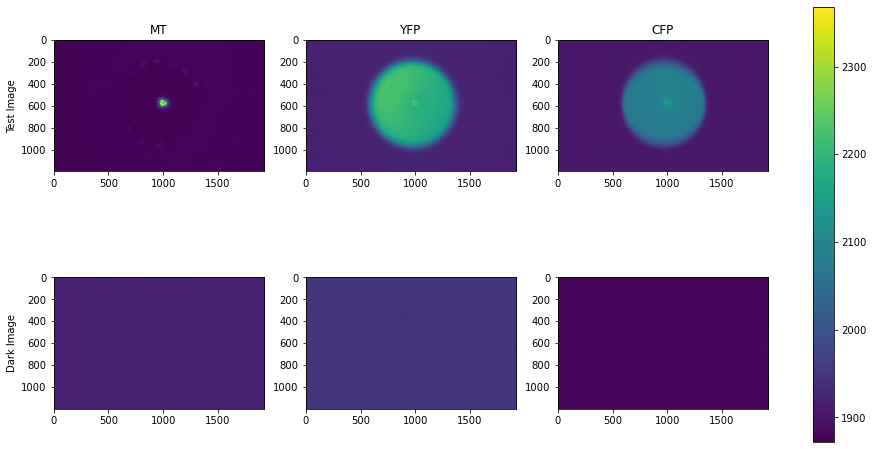

In [17]:
frame = 40
im_MT = im_arrayBrightpos0[frame]
im_YFP = im_arrayYFPpos0[frame]
im_CFP = im_arrayCFPpos0[frame]

colorbar_min = np.percentile(im_YFP, 100)
colorbar_max = np.percentile(im_CFP, 0)

fig, ax = plt.subplots(2, 3, figsize=(16, 8))
cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
cb_setting=cm.ScalarMappable(norm=normalizer)


ax[0,0].imshow(im_MT)
ax[0,0].set_title('MT')
ax[0,0].set_ylabel('Test Image')

ax[0,1].imshow(im_YFP)
ax[0,1].set_title('YFP')

ax[0,2].imshow(im_CFP)
ax[0,2].set_title('CFP')

ax[1,0].imshow(im_MT_dark_rd)
ax[1,0].set_ylabel('Dark Image')

ax[1,1].imshow(im_YFP_dark_rd)
ax[1,2].imshow(im_CFP_dark_rd)

fig.colorbar(cb_setting, ax=ax.ravel().tolist());

### Correct Background

Subtract the dark image backgrounds:

In [18]:
im_arrayBrightpos0_bs = im_arrayBrightpos0 - im_MT_dark_rd
im_arrayYFPpos0_bs = im_arrayYFPpos0 - im_YFP_dark_rd
im_arrayCFPpos0_bs = im_arrayCFPpos0 - im_CFP_dark_rd

Show a set of background subtracted images:

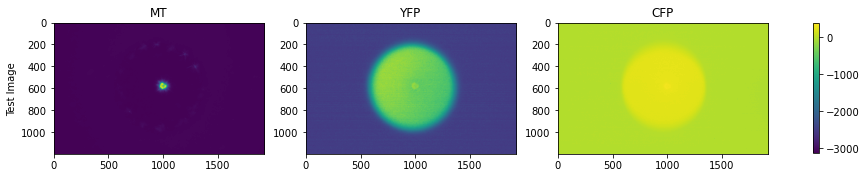

In [19]:
frame = 40
im_MT_bs = im_arrayBrightpos0_bs[frame]
im_YFP_bs = im_arrayYFPpos0_bs[frame]
im_CFP_bs = im_arrayCFPpos0_bs[frame]

colorbar_min = np.percentile(im_YFP_bs, 100)
colorbar_max = np.percentile(im_CFP_bs, 0)

fig, ax = plt.subplots(1, 3, figsize=(16, 8))
cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
cb_setting=cm.ScalarMappable(norm=normalizer)


ax[0].imshow(im_MT_bs)
ax[0].set_title('MT')
ax[0].set_ylabel('Test Image')

ax[1].imshow(im_YFP_bs)
ax[1].set_title('YFP')

ax[2].imshow(im_CFP_bs)
ax[2].set_title('CFP')

fig.colorbar(cb_setting, shrink=0.3, ax=ax.ravel().tolist());

In [19]:
print('YFP upper: ' + str(np.percentile(im_YFP_bs, 100)) + ', YFP lower: ' +str(np.percentile(im_YFP_bs, 4)))
print('CFP upper: ' + str(np.percentile(im_CFP_bs, 100)) + ', CFP lower: ' +str(np.percentile(im_CFP_bs, 4)))

YFP upper: 1868.8, YFP lower: 1443.2
CFP upper: 1859.2, CFP lower: 1439.3600000000001


### Crop and Register Images

Define crop windows

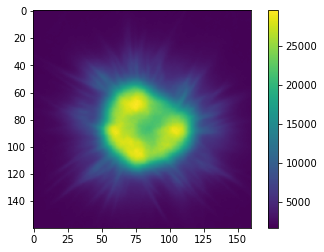

In [20]:
wc_ymin, wc_ymax, wc_xmin, wc_xmax = 300, 870, 700, 1230 
wide_crop = np.s_[wc_ymin:wc_ymax, wc_xmin:wc_xmax]
tc_ymin, tc_ymax, tc_xmin, tc_xmax = 495, 655, 910, 1070 
tight_crop = np.s_[tc_ymin:tc_ymax, tc_xmin:tc_xmax]
#center = 575, 990
plt.imshow(im_MT_bs[tight_crop], vmin = np.percentile(im_MT_bs, 0), vmax = np.percentile(im_MT_bs, 100))
plt.colorbar()

#### Single Aster:

Otsu thresholding, contour, and circle definitions

In [21]:
frame=6
image = im_arrayBrightpos0_bs[frame][wide_crop]
thresh = threshold_otsu(image)
binary = (image > thresh).astype(np.uint8)

contours,hierarchy = cv2.findContours(binary, 1, 2)
print(np.shape(contours))
cnt = contours[30]

(x,y),radius = cv2.minEnclosingCircle(cnt)
center = (int(x),int(y))
radius = int(radius)

#cv2.circle(image,center,radius,(0,255,0),2)

print(center)
print(radius)

(67,)
(247, 303)
9


/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


plot the image and the center found with the contour

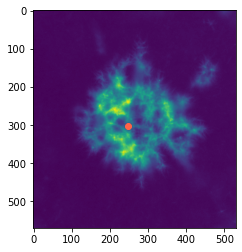

In [22]:
plt.imshow(image)
plt.scatter(x, y, color = 'tomato')

Demonstration of otsu thresholding

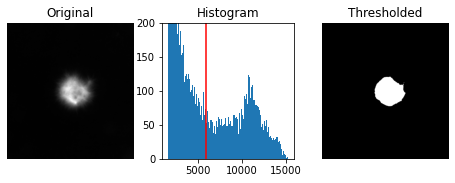

In [23]:
frame=10
image = im_arrayBrightpos0_bs[frame][wide_crop]
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=300)
labeled_foreground = (image > thresh).astype(int)
properties = regionprops(labeled_foreground, image)
center_of_mass = properties[0].centroid
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')
ax[1].set_ylim(0, 200)

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()


#### All asters:

Below is my best work at automated center detection. I use Otsu thresholding (This process works well for a bimodal histogram. The process finds the place between the peaks that minimizes the variance between the points. It well detects the areas of microtubules or cores from background). I turn the image into a binary image with the MT channel as all ones. Then I use packages from the OpenCV package, cv2. This package allows us to define contours (regions of continuous intensity). From the contours, cv2 can find the smallest circle that entirely encloses the microtubule region, from which a center can be defined

In [24]:
centers_tc = []
radii = []
frame_num = []

for i, im in enumerate(im_arrayBrightpos0_bs):
    #set image to iterate and crop size
    image = im[tight_crop]
    
    #perform otsu thresholding
    thresh = threshold_otsu(image)
    binary = (image > thresh).astype(np.uint8)
    
    #create a contour
    contours,hierarchy = cv2.findContours(binary, 1, 2)
    
    #iterate through contours that only have one solution (aster has contracted enough into one continuous region)
    if np.shape(contours)[0] == 1:
        cnt = contours[0]
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        centers_tc.append([x, y])
        radii.append(radius)
        frame_num.append(i)
        
centers_tc = np.array(centers_tc)
radii = np.array(radii)
frame_num = np.array(frame_num)

Adjust the centers so the units are in terms of the full field image.

In [25]:
centers = []
for center in centers_tc:
    center_x = center[0] + tc_xmin
    center_y = center[1] + tc_ymin
    centers.append([center_x, center_y])
centers = np.array(centers)

Plot all of the included frames with center markings

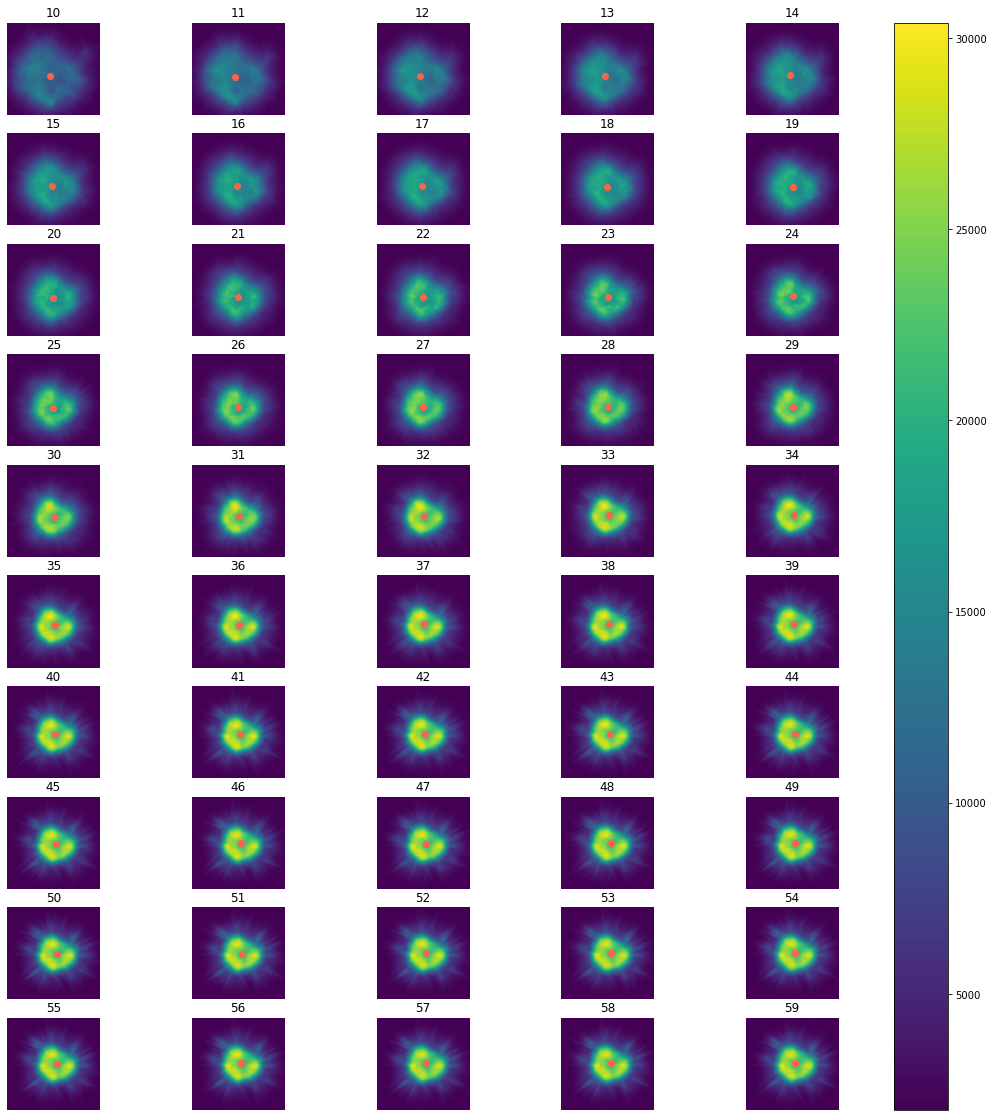

In [26]:
colorbar_min = np.percentile(im_arrayBrightpos0_bs, 80)
colorbar_max = np.percentile(im_arrayBrightpos0_bs, 100)

fig, axes = plt.subplots(nrows=int((len(frame_num)+0.5)/5), ncols=5, figsize = (20, 20))
cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    frame = frame_num[i]
    ax.imshow((im_arrayBrightpos0_bs[frame][tight_crop]),cmap=cmap,norm=normalizer)
    ax.scatter(centers_tc[i][0], centers_tc[i][1], color = 'tomato')
    ax.set_title(str(frame))
    ax.axis('off')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

Calculate the shifts

In [27]:
shifts = []
for i in frame_num:
    shift, error, _ = phase_cross_correlation(im_arrayYFPpos0_bs[i][tight_crop], im_arrayCFPpos0_bs[i][tight_crop])
    shifts.append(shift)
shifts = np.array(shifts)

### Ratio and Trace

Define all the appropriate crops and traces for each image

In [28]:
winsize = 100
thickness = 5

#cropped aster images
im_arrayYFPpos0_plot = []
im_arrayCFPpos0_plot = []
im_arrayBrightpos0_plot = []
ratios_plot = []

#Traces for asters
YFP_trace_pts = []
CFP_trace_pts = []
MT_trace_pts = []
ratios_trace_pts = []

for i, frame in enumerate(frame_num):
    
    #Set the window parameters
    i_min = int(centers[i][0] - winsize)
    i_max = int(centers[i][0] + winsize)
    j_min = int(centers[i][1] - winsize)
    j_max = int(centers[i][1] +  winsize)
    
    #demi-variable for shift
    shift_j = int(shifts[i][0])
    shift_i = int(shifts[i][1])
    
    #set YFP and CFP windows
    winYFP = np.s_[j_min:j_max, i_min:i_max]
    winCFP = np.s_[(j_min-shift_j) : (j_max-shift_j), (i_min-shift_i) : (i_max-shift_i)]
    
    #Append the plotting images
    im_arrayYFPpos0_plot.append(im_arrayYFPpos0_bs[frame][winYFP])
    im_arrayCFPpos0_plot.append(im_arrayCFPpos0_bs[frame][winCFP])
    im_arrayBrightpos0_plot.append(im_arrayBrightpos0_bs[frame][winCFP]) #for now MT same as CFP shifts, running the shift cell seems closest to CFP
    
    ratio = im_arrayYFPpos0_bs[frame][winYFP] / im_arrayCFPpos0_bs[frame][winCFP]
    ratios_plot.append(ratio)
    
    #Define a narrow srip to take trace values
    YFP_trace = im_arrayYFPpos0_plot[i][(winsize-thickness):(winsize+thickness), :]
    CFP_trace = im_arrayCFPpos0_plot[i][(winsize-thickness):(winsize+thickness), :]
    MT_trace = im_arrayBrightpos0_plot[i][(winsize-thickness):(winsize+thickness), :]
    ratios_trace = ratios_plot[i][(winsize-thickness):(winsize+thickness), :]
    
    #average the strips
    YFP_trace_pts.append(np.average(YFP_trace, axis=0))
    CFP_trace_pts.append(np.average(CFP_trace, axis=0))
    MT_trace_pts.append(np.average(MT_trace, axis=0))
    ratios_trace_pts.append(np.average(ratios_trace, axis=0))
                       
im_arrayYFPpos0_plot = np.array(im_arrayYFPpos0_plot)
im_arrayCFPpos0_plot = np.array(im_arrayCFPpos0_plot)
im_arrayBrightpos0_plot = np.array(im_arrayBrightpos0_plot)
ratios_plot = np.array(ratios_plot)

YFP_trace_pts = np.array(YFP_trace_pts)
CFP_trace_pts = np.array(CFP_trace_pts)
MT_trace_pts = np.array(MT_trace_pts)
ratios_trace_pts = np.array(ratios_trace_pts)

Show cropped image

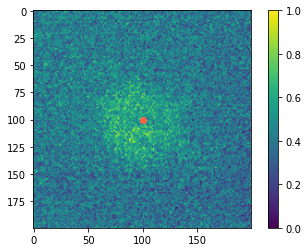

In [29]:
#plt.imshow(im_arrayCFPpos0_plot[20][(winsize-thickness):(winsize+thickness), :])
plt.imshow(im_arrayCFPpos0_plot[10])
plt.scatter(100, 100, color="tomato")
plt.colorbar()


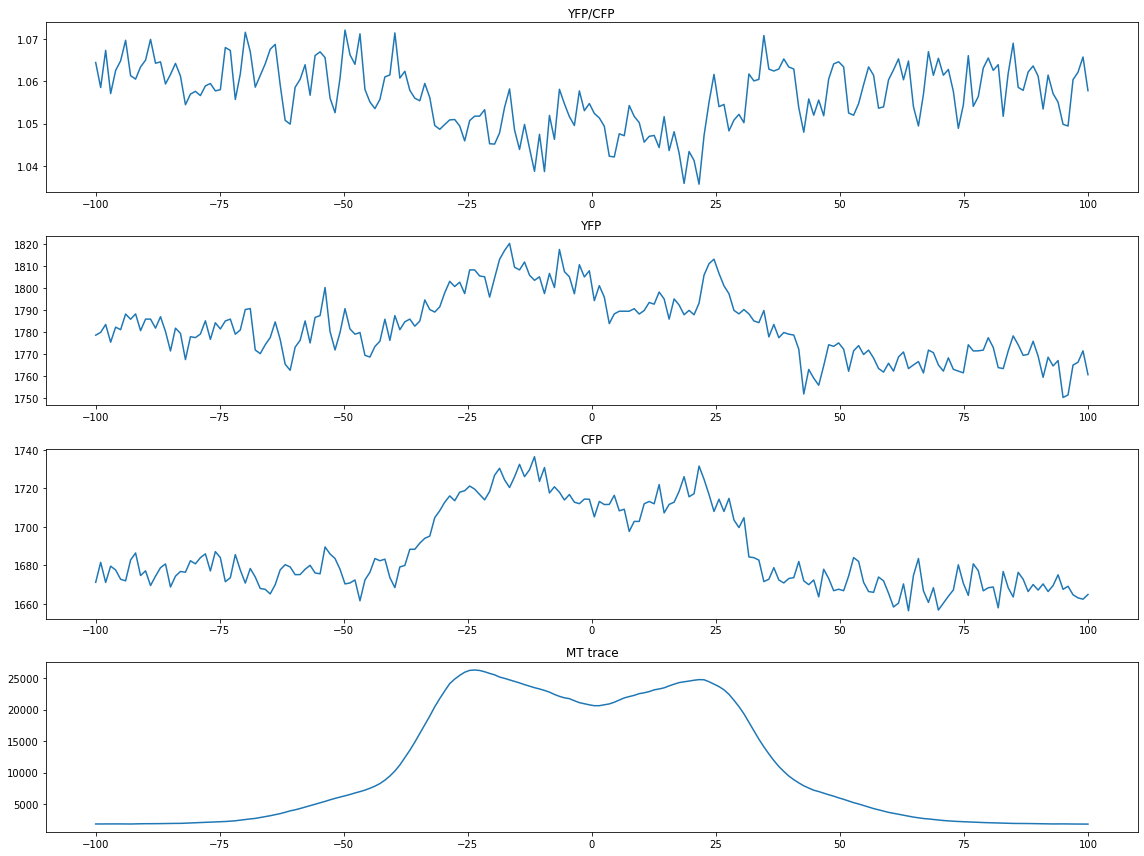

In [31]:
pos = np.linspace(-winsize, winsize, 2*winsize)

fig, ax = plt.subplots(4, figsize = (16, 12))
ax[0].plot(pos, ratios_trace_pts[20])
ax[0].set_title("YFP/CFP")

ax[1].plot(pos, YFP_trace_pts[20])
ax[1].set_title("YFP")

ax[2].plot(pos, CFP_trace_pts[20])
ax[2].set_title("CFP")

ax[3].plot(pos, MT_trace_pts[20])
ax[3].set_title("MT trace")
plt.tight_layout();

## Radial Trace

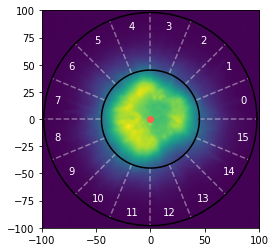

In [34]:
#######################################################################
# --------------- Show aster with boundaries & wedges --------------- #
#######################################################################

im = im_arrayBrightpos0_plot[10]
r_inner_um = radii[10]
r_outer_um = 100
W,_ = im.shape
W_half=int(0.5*W)

plt.imshow(im, \
           origin='lower', \
           extent = (-r_outer_um, r_outer_um, -r_outer_um, r_outer_um),\
           vmin = np.percentile(im, 0), vmax = np.percentile(im, 100),\
           cmap = "viridis")

n_wedge = 16
angle_bins = np.radians(np.linspace(0,360,n_wedge+1))
angles = 0.5*(angle_bins[1:] + angle_bins[0:-1])

for i in range(len(angle_bins)-1):
    angle = angle_bins[i]
    xx = [r_inner_um*np.cos(angle), 0.98*r_outer_um*np.cos(angle)]
    yy = [r_inner_um*np.sin(angle), 0.98*r_outer_um*np.sin(angle)]
    plt.plot(xx, yy, '--', color='w', alpha=0.4)

    dangle = angle_bins[1]-angle_bins[0]
    x_text = 0.87*r_outer_um*np.cos(angle+0.5*dangle)
    y_text = 0.87*r_outer_um*np.sin(angle+0.5*dangle)
    plt.text(x_text, y_text, str(i), color='w', alpha=1,\
             horizontalalignment='center', verticalalignment='center')

thetas = np.linspace(0,2*np.pi,200)

x_circ_inner = r_inner_um*np.cos(thetas)
y_circ_inner = r_inner_um*np.sin(thetas)
plt.plot(x_circ_inner, y_circ_inner, color='black', alpha=1)

x_circ_outer = 0.98*r_outer_um*np.cos(thetas)
y_circ_outer = 0.98*r_outer_um*np.sin(thetas)
plt.plot(x_circ_outer, y_circ_outer, color='black', alpha=1)
plt.scatter(0,0, color="tomato")

In [57]:
output_YFP = []
output_CFP = []
output_MT = []
output_ratios = []

for i, frame in tqdm(enumerate(frame_num)):
    
    prof_YFP = profile_fn(im_arrayYFPpos0_plot[i], r_min=radii[i], r_max=100, avg_method='median', n_positions=num_pos)
    prof_CFP = profile_fn(im_arrayCFPpos0_plot[i], r_min=radii[i], r_max=100, avg_method='median', n_positions=num_pos)
    prof_MT = profile_fn(im_arrayBrightpos0_plot[i], r_min=radii[i], r_max=100, avg_method='median', n_positions=num_pos)
    prof_ratios = profile_fn(ratios_plot[i], r_min=0, r_max=100, avg_method='median', n_positions=num_pos)
    
    output_YFP.append(prof_YFP)
    output_CFP.append(prof_CFP)
    output_MT.append(prof_MT)
    output_ratios.append(prof_ratios)


0it [00:00, ?it/s]

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
num_pos = len(frame_num)
r_inner_px = radii
r_outer_px = np.ones(num_pos)*100


for i, frame in enumerate(frame_num):
    output_YFP = profile_fn(im_arrayYFPpos0_plot, r_min=r_inner_px, r_max=r_outer_px, avg_method='median', n_positions=num_pos)
    output_CFP = profile_fn(im_arrayCFPpos0_plot, r_min=r_inner_px, r_max=r_outer_px, avg_method='median', n_positions=num_pos)
    output_MT = profile_fn(im_arrayBrightpos0_plot, r_min=r_inner_px, r_max=r_outer_px, avg_method='median', n_positions=num_pos)

In [ ]:
start here need to input all the right info:

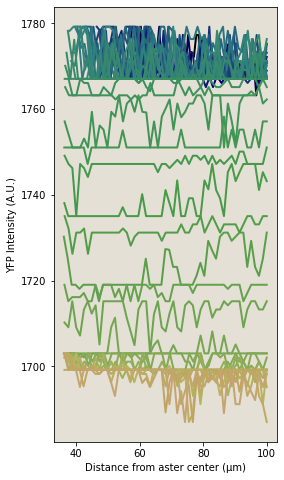

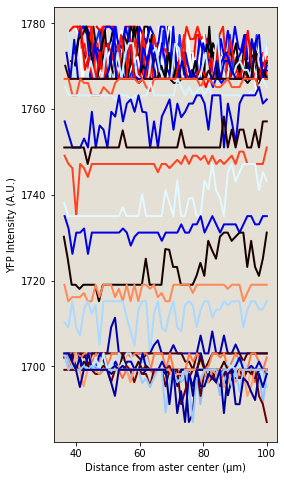

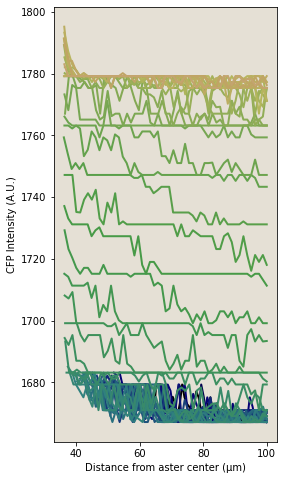

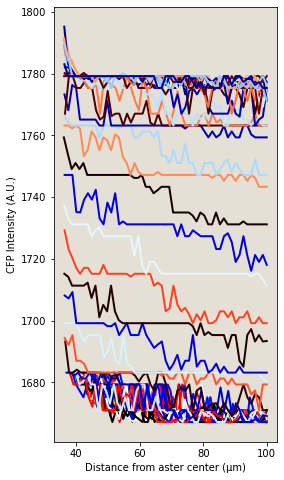

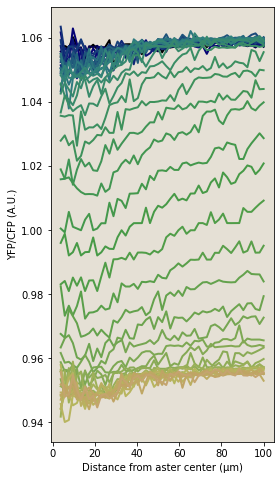

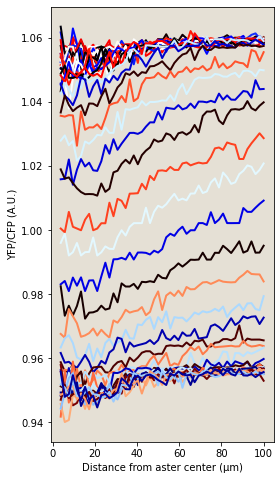

In [63]:
#Define the frames to plot
plot_frames = frame_num[:-2]
plot_times=frame_num*20/60 #min

### Plot YFP ###

#--- earth ---#

fig, ax = plt.subplots(figsize=(4, 8)) 
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8, len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_YFP[i]['r_unif_ls'], output_YFP[i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('YFP Intensity (A.U.)')
ax.set_facecolor(color_background)

#--- flag ---#

fig, ax = plt.subplots(figsize=(4, 8)) 
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_YFP[i]['r_unif_ls'], output_YFP[i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('YFP Intensity (A.U.)')
ax.set_facecolor(color_background) 


### Plot CFP ###

#--- earth ---#

fig, ax = plt.subplots(figsize=(4, 8)) 
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8, len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_CFP[i]['r_unif_ls'], output_CFP
             [i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('CFP Intensity (A.U.)')
ax.set_facecolor(color_background) 

#--- flag ---#

fig, ax = plt.subplots(figsize=(4, 8)) 
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_CFP[i]['r_unif_ls'], output_CFP
             [i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('CFP Intensity (A.U.)')
ax.set_facecolor(color_background) 


### Plot Ratio ###

#--- earth ---#

fig, ax = plt.subplots(figsize=(4, 8)) 
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8, len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_ratios[i]['r_unif_ls'], output_ratios
             [i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('YFP/CFP (A.U.)')
ax.set_facecolor(color_background) 

#--- flag ---#

fig, ax = plt.subplots(figsize=(4, 8)) 
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_ratios[i]['r_unif_ls'], output_ratios
             [i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('YFP/CFP (A.U.)')
ax.set_facecolor(color_background) 

# #path to save image
# file_path = '../../Analyzed_Data/Aster/2021-06-10_Filter3_250ATP_mCherryiATP_1_MMStack_Pos2/'
# file_name = 'mot_time_series_28-36'
# #fig.savefig(file_path + file_name, dpi=300, bbox_inches='tight')

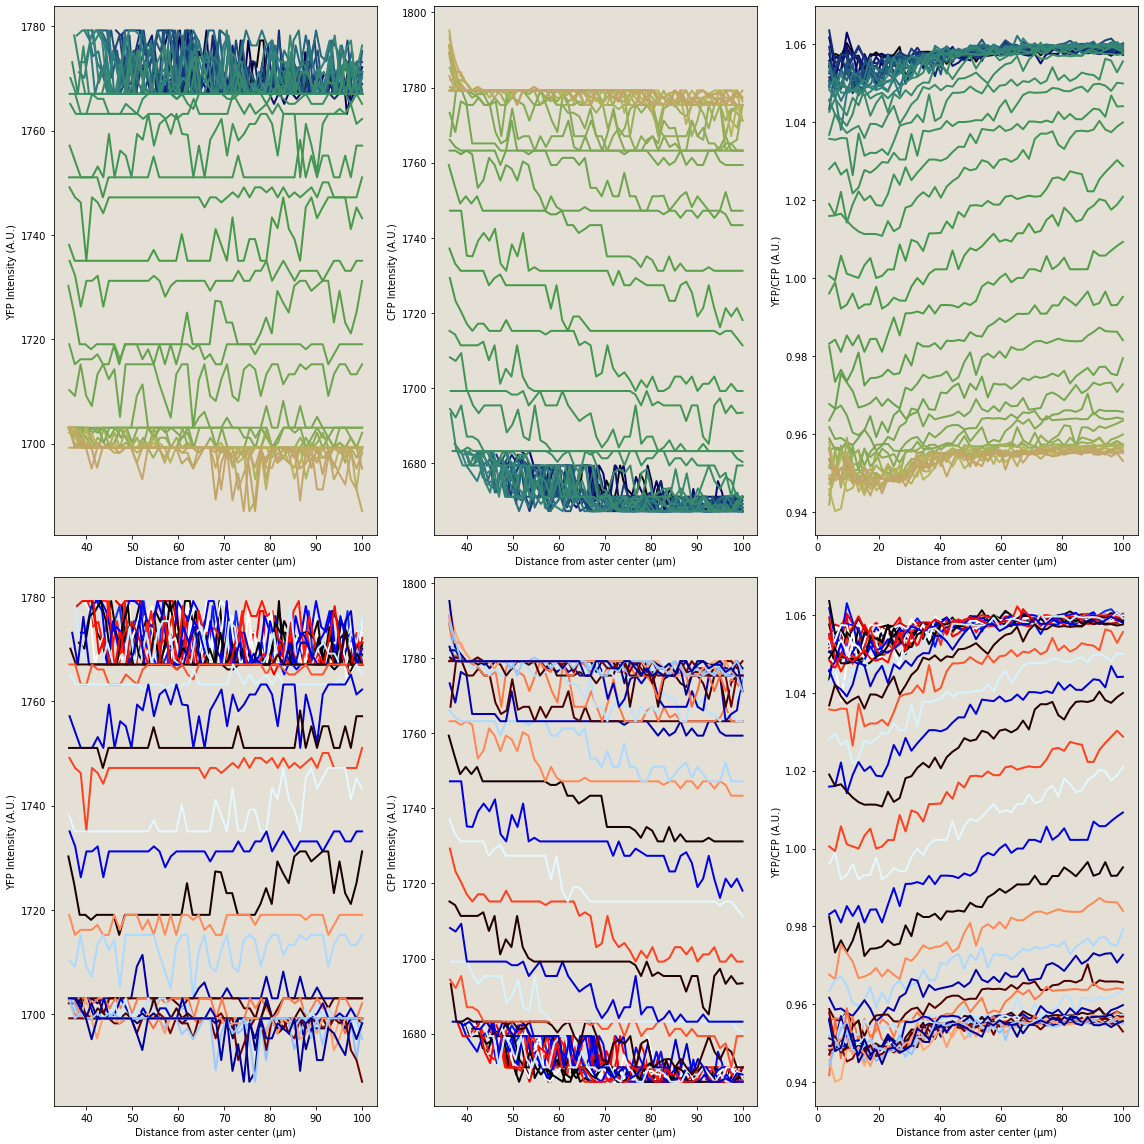

In [95]:
#Define the frames to plot
plot_frames = frame_num[:-2]
plot_times=frame_num*20/60 #min


fig, ax = plt.subplots(2, 3, figsize=(16, 16)) 
#plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8, len(plot_frames)))))
ax[0,0].set_prop_cycle(plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8, len(plot_frames)))))
ax[0,1].set_prop_cycle(plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8, len(plot_frames)))))
ax[0,2].set_prop_cycle(plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8, len(plot_frames)))))
ax[1,0].set_prop_cycle(plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))
ax[1,1].set_prop_cycle(plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))
ax[1,2].set_prop_cycle(plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))

for i, frame in enumerate(plot_frames):
    ax[0,0].plot(output_YFP[i]['r_unif_ls'], output_YFP[i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[0,0].set_xlabel('Distance from aster center (µm)')
ax[0,0].set_ylabel('YFP Intensity (A.U.)')
ax[0,0].set_facecolor(color_background)


for i, frame in enumerate(plot_frames):
    ax[0,1].plot(output_CFP[i]['r_unif_ls'], output_CFP[i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[0,1].set_xlabel('Distance from aster center (µm)')
ax[0,1].set_ylabel('CFP Intensity (A.U.)')
ax[0,1].set_facecolor(color_background)


for i, frame in enumerate(plot_frames):
    ax[0,2].plot(output_ratios[i]['r_unif_ls'], output_ratios[i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[0,2].set_xlabel('Distance from aster center (µm)')
ax[0,2].set_ylabel('YFP/CFP (A.U.)')
ax[0,2].set_facecolor(color_background)

# ----- Flag same as above ----#
for i, frame in enumerate(plot_frames):
    ax[1,0].plot(output_YFP[i]['r_unif_ls'], output_YFP[i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[1,0].set_xlabel('Distance from aster center (µm)')
ax[1,0].set_ylabel('YFP Intensity (A.U.)')
ax[1,0].set_facecolor(color_background)


for i, frame in enumerate(plot_frames):
    ax[1,1].plot(output_CFP[i]['r_unif_ls'], output_CFP[i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[1,1].set_xlabel('Distance from aster center (µm)')
ax[1,1].set_ylabel('CFP Intensity (A.U.)')
ax[1,1].set_facecolor(color_background)


for i, frame in enumerate(plot_frames):
    ax[1,2].plot(output_ratios[i]['r_unif_ls'], output_ratios[i]['avg_ls'],lw=2, label= str(round(plot_times[i],2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[1,2].set_xlabel('Distance from aster center (µm)')
ax[1,2].set_ylabel('YFP/CFP (A.U.)')
ax[1,2].set_facecolor(color_background)

plt.tight_layout();



In [ ]:
im_ratios = im_arrayYFPpos0_plot/im_arrayCFPpos0_plot
thickness = 10
ratiowin = np.s_[95:105, :]
mt_trace = im_MT_bs[winYFP][ratiowin]
YFP_trace = im_YFP_bs[winYFP][ratiowin]
CFP_trace = im_CFP_bs[winCFP][ratiowin]
plt.imshow(ratio)
plt.imshow(CFP_trace)
plt.colorbar()
plt.tight_layout();

## Crop based on shift

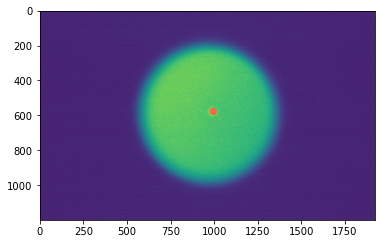

In [160]:
plt.imshow(im_arrayYFPpos0_bs[frame])
plt.scatter(centers[frame][0],centers[frame][1], color = 'tomato')

Text(0.5, 1.0, '30')

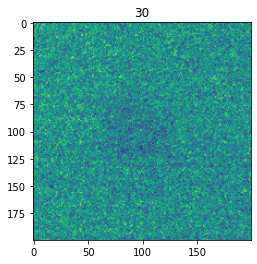

In [161]:
winsize = 100
index = 20
frame = frame_num[index]
# np.s_ sets up an index tuple. Here define the window of interest:
i_min = int(centers[index][0] - winsize)
i_max = int(centers[index][0] + winsize)
j_min = int(centers[index][1] - winsize)
j_max = int(centers[index][1] +  winsize)

winYFP = np.s_[j_min:j_max, i_min:i_max]
winCFP = np.s_[int(j_min-int(shifts[index][0])):int(j_max-int(shifts[index][0])), int(i_min-int(shifts[index][1])):int(i_max-int(shifts[index][1]))]

plt.imshow(im_arrayYFPpos0_bs[frame][winYFP]/im_arrayCFPpos0_bs[frame][winCFP])
plt.title(str(frame))

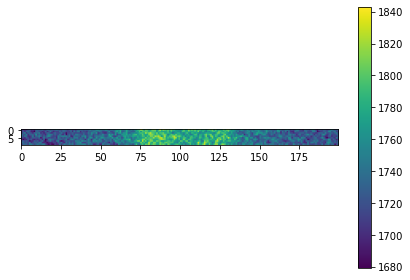

In [162]:
ratio = im_YFP_bs[winYFP]/im_CFP_bs[winCFP]
ratiowin = np.s_[95:105, :]
mt_trace = im_MT_bs[winYFP][ratiowin]
YFP_trace = im_YFP_bs[winYFP][ratiowin]
CFP_trace = im_CFP_bs[winCFP][ratiowin]
plt.imshow(ratio)
plt.imshow(CFP_trace)
plt.colorbar()
plt.tight_layout();

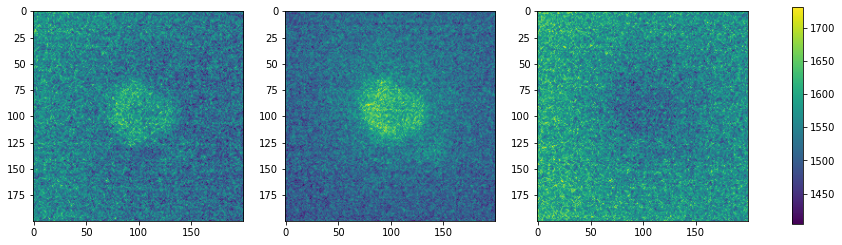

In [163]:
colorbar_min = np.percentile(im_YFP_bs, 90)
colorbar_max = np.percentile(im_YFP_bs, 0)

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
cb_setting=cm.ScalarMappable(norm=normalizer)

ax[0].imshow(im_YFP_bs[winYFP])
ax[1].imshow(im_CFP_bs[winCFP])
ax[2].imshow(ratio)

fig.colorbar(cb_setting, ax=ax.ravel().tolist(), shrink = 0.5);

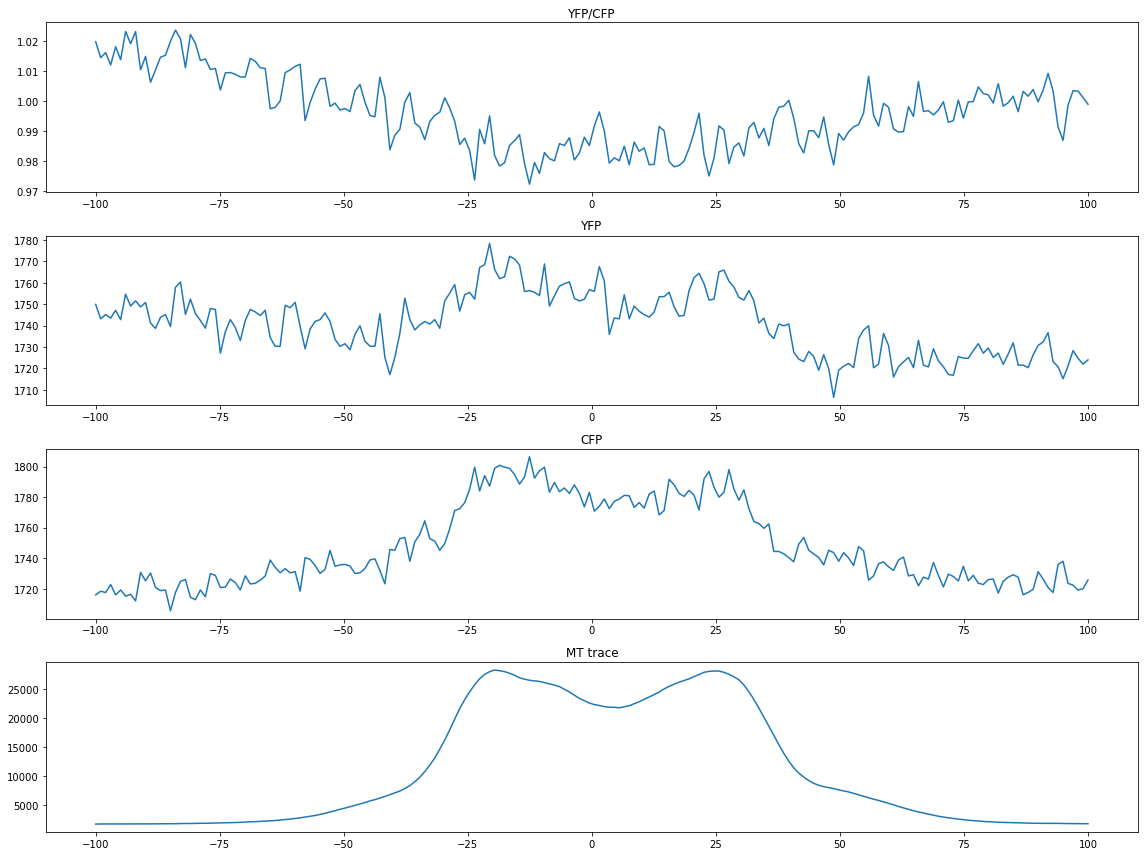

In [164]:
pos = np.linspace(-winsize, winsize, 2*winsize)
inten = np.average(ratio[ratiowin], axis=0)
mt_trace_pts = np.average(mt_trace, axis=0)
YFP_trace_pts = np.average(YFP_trace, axis=0)
CFP_trace_pts = np.average(CFP_trace, axis=0)


fig, ax = plt.subplots(4, figsize = (16, 12))
ax[0].plot(pos, inten)
ax[0].set_title("YFP/CFP")

ax[1].plot(pos, YFP_trace_pts)
ax[1].set_title("YFP")

ax[2].plot(pos, CFP_trace_pts)
ax[2].set_title("CFP")

ax[3].plot(pos, mt_trace_pts)
ax[3].set_title("MT trace")
plt.tight_layout();